In [1]:
#Import

import os
import cv2
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

c:\Users\dusrb\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Utils

# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [3]:
#Custom Dataset

class SatelliteDataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
                
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_rle = self.data.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

In [7]:
#Data Loader

transform = A.Compose(
    [   
        A.Resize(224, 224),
        A.Normalize(),
        ToTensorV2()
    ]
)

dataset = SatelliteDataset(csv_file='train.csv', transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)

C:\Users\dusrb\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:9: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  if __name__ == "__main__":
C:\Users\dusrb\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == "__main__":
Clipping input data to the valid range for imshow 

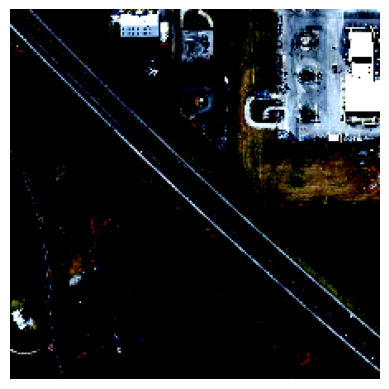

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


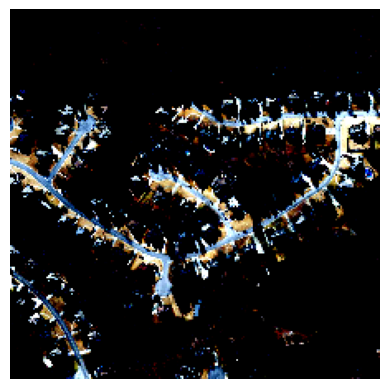

In [10]:
import matplotlib.pyplot as plt

images = []
for i in range(2):
    image, mask = dataset[i]
    images.append(image)

# 리스트를 numpy 배열로 변환
images = np.array(images)

# 이미지 시각화 함수
def imshow(image):
    image = np.transpose(image, (1, 2, 0))  # (채널, 높이, 너비) -> (높이, 너비, 채널)
    plt.imshow(image)
    plt.axis('off')
    plt.show()


# 이미지 시각화
for i in range(2):
    image = images[i]
    imshow(image)


In [11]:
#Define Model

# U-Net의 기본 구성 요소인 Double Convolution Block을 정의합니다.
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

# 간단한 U-Net 모델 정의
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   

        x = self.dconv_down4(x)

        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out

In [19]:
#Model Train
from tqdm import tqdm_notebook  # tqdm.notebook을 임포트합니다

# model 초기화
model = UNet().to(device)

# loss function과 optimizer 정의
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# training loop
for epoch in range(10):  # 10 에폭 동안 학습합니다.
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(dataloader):
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.unsqueeze(1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(dataloader)}')

C:\Users\dusrb\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [ ]:
#Inference

test_dataset = SatelliteDataset(csv_file='./test.csv', transform=transform, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

with torch.no_grad():
    model.eval()
    result = []
    for images in tqdm(test_dataloader):
        images = images.float().to(device)
        
        outputs = model(images)
        masks = torch.sigmoid(outputs).cpu().numpy()
        masks = np.squeeze(masks, axis=1)
        masks = (masks > 0.35).astype(np.uint8) # Threshold = 0.35
        
        for i in range(len(images)):
            mask_rle = rle_encode(masks[i])
            if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                result.append(-1)
            else:
                result.append(mask_rle)

In [ ]:
#Submission

submit = pd.read_csv('./sample_submission.csv')
submit['mask_rle'] = result

submit.to_csv('./submit.csv', index=False)